# Part Pre: Data Cleansing & Constructing

In [3]:
import re
import time
import os
import inspect
import random
import json
import utilies
import joblib
import rdkit
import pickle  as pk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from rdkit_utils import smiles_dataset
from utilies import save_dataset, get_parameters
from utilies import fit_result, get_parameters
from utilies import pipeline_optim
from utilies import plot_multi_learning_curves

from PIL import Image
from sklearn.manifold import TSNE

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from importlib       import reload 
from IPython.display import Image

In [2]:
dataset_original = pd.read_csv('./datasets/CHEMBL_SOS1_Inhibitors_CHEMBL2079846_download on 20221028(1).csv', delimiter=';')

# Take out all values that have pChEMBL values
dataset_v1 = dataset_original[dataset_original['pChEMBL Value'].notna()]

# Check out the duplicates and take their mean values
dataset_v2 = dataset_v1.groupby('Molecule ChEMBL ID').mean()['Standard Value'].reset_index()

# calculate pChEMBL values
s_value = dataset_v2['Standard Value'].values
p_value = np.around(- np.log10(s_value/(10**(9))), 2)
dataset_v2['Calculated pChEMBL'] = p_value.tolist()

for i in range(0, dataset_v2.shape[0]):
    index = dataset_v2['Molecule ChEMBL ID'][i]
    smile = dataset_v1.loc[dataset_v1['Molecule ChEMBL ID'] == index]['Smiles'].drop_duplicates()
    dataframe = pd.DataFrame(smile)

    if i == 0:
        concat_df = dataframe
    else:
        concat_df = pd.concat([concat_df, dataframe], axis = 0)
        
concat_df = concat_df.reset_index()

all_structures = pd.concat([dataset_v2, concat_df], axis = 1)
save_dataset(all_structures)

dataset = pd.read_csv('./datasets/all_structures.csv')
dic = get_parameters(path = './settings/fp_settings.json', print_dict = False)

x = smiles_dataset(dataset_df = dataset, smiles_loc = 'Smiles',
                   fp_radius = dic.get("fp_radius"), fp_bits = dic.get("fp_bits"))

y = dataset['Calculated pChEMBL']

# change file_name to save as different datasets
save_dataset(x, file_name = dic.get("dataset_name"), idx = False)
save_dataset(y, file_name = dic.get("label_name"), idx = False)

Current path is: C:\Users\shxld1\Downloads\ML-for-SOS1-main\datasets
Path already existed.
Dataset saved successfully.
json file path is: ./settings/fp_settings.json
Current path is: C:\Users\shxld1\Downloads\ML-for-SOS1-main\datasets
Path already existed.
Dataset saved successfully.
Current path is: C:\Users\shxld1\Downloads\ML-for-SOS1-main\datasets
Path already existed.
Dataset saved successfully.


# Part A: Clustering

Current path is: C:\Users\shxld1\Downloads\ML-for-SOS1-main\figures
Path already existed.


C:\Users\shxld1\.conda\envs\AIDD_3.7\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\shxld1\.conda\envs\AIDD_3.7\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


AttributeError: type object 'Image' has no attribute 'open'

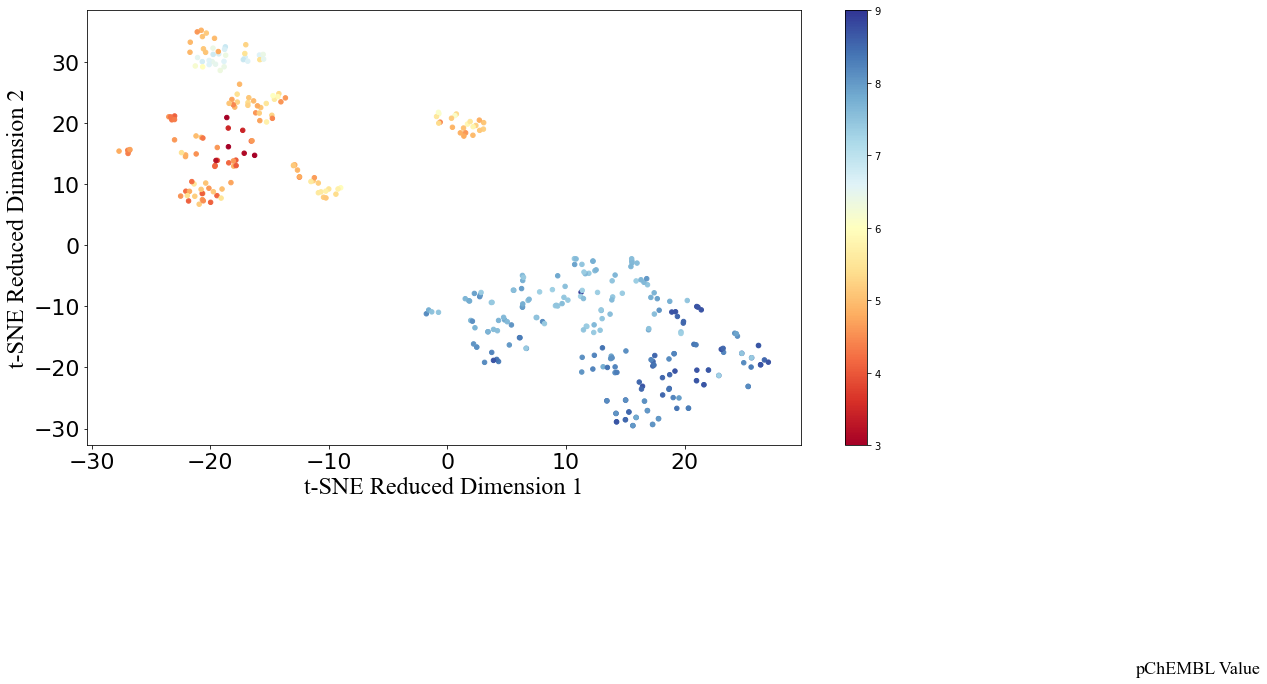

In [6]:
np.random.seed(42)

path = os.path.join(os.getcwd(), 'figures')
print('Current path is:', path)

if os.path.exists(path) == True:
    pass
    print('Path already existed.')
else:
    os.mkdir(path)
    print('Path created.')

x_values = pd.read_csv('./datasets/3_512_x_main.csv').values
y_values = pd.read_csv('./datasets/3_512_y_main.csv').values.ravel()
tsne_descriptors = TSNE(n_components=2, random_state = 42)
x_tsne = tsne_descriptors.fit_transform(x_values)


# draw tsne
cm = plt.cm.get_cmap('RdYlBu')
plt.figure(figsize=(16, 8))
plt.xticks(size = 22)
plt.yticks(size = 22)
plt.xlabel('t-SNE Reduced Dimension 1',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('t-SNE Reduced Dimension 2',fontproperties = 'Times New Roman', size = 24)
plt.scatter(x_tsne[:, 0], x_tsne[:,1],c= y_values,vmin= 3, vmax= 9, s= 20, cmap=cm)
plt.colorbar()
plt.text(58, -70, "pChEMBL Value", fontproperties = 'Times New Roman', size = 18)
plt.savefig("figures/TSNE.png", bbox_inches='tight', pad_inches= 0)

tsne_image = Image.open('figures/TSNE.png')
tsne_image.show()

In [ ]:
# Print all inactive molecules with their pChemble values in selected cluster 01 (threshold 7)

i = 0

Draw_01 = []
Cluster_01 = []
display_table = []
DATASET = dataset.values

for i in range(375):
    
    if x_tsne[i, 0] >= -30 and x_tsne[i, 0] <= 10:
        if x_tsne[i, 1] >= 3:
            print('\nIndex ', i, ': ', y_values[i], '\n\n', DATASET[i, 4])
            Cluster_01.append(i)
            Draw_01.append(Chem.MolFromSmiles(DATASET[i, 4]))
            display_table.append([DATASET[i, 4], y_values[i]])
    
    i += 1    
pd.set_option('display.max_rows', 200)
display(pd.DataFrame(display_table, columns=['SMILES', 'pChEMBL Value']))
img_01 = Draw.MolsToGridImage(Draw_01, molsPerRow = 4, subImgSize = (500,500), legends = [str(y_values[i]) for i in Cluster_01], returnPNG = False, maxMols=500)    
img_01.save('./images/Structure_01.png')

Image('./images/Structure_01.png')
pd.DataFrame(display_table, columns=['SMILES', 'pChEMBL Value']).to_csv('./datasets/molecules pChembl values less than 7.csv')

In [7]:
# Print all active molecules with their pChemble values in selected cluster 02 (threshold 7)

i = 0

Draw_02 = []
Cluster_02 = []
display_table = []
DATASET = dataset.values

for i in range(375):
    
    if x_tsne[i, 0] >= -8 and x_tsne[i, 0] <= 30:
        if x_tsne[i, 1] <= 3:
            print('\nIndex ', i, ': ', y_values[i], '\n\n', DATASET[i, 4])
            Cluster_02.append(i)
            Draw_02.append(Chem.MolFromSmiles(DATASET[i, 4]))
            display_table.append([DATASET[i, 4], y_values[i]])
    
    i += 1
pd.set_option('display.max_rows', 200)
display(pd.DataFrame(display_table, columns=['SMILES', 'pChEMBL Value']))
pd.DataFrame(display_table, columns=['SMILES', 'pChEMBL Value']).sort_values(by=['pChEMBL Value'], ascending=False).to_csv('./datasets/molecules pChembl values more than 7.csv')
img_02 = Draw.MolsToGridImage(Draw_02, molsPerRow = 4, subImgSize = (500,500), legends = [str(y_values[i]) for i in Cluster_02], returnPNG = False, maxMols=500)    
img_02.save('./images/Structure_02.png')

Image('./images/Structure_02.png')


Index  110 :  8.1 

 COc1cc2nc(C)nc(N[C@H](C)c3cccc(C(C)(C)O)c3)c2cc1[C@H]1CC[C@H](C(=O)N(C)C)CC1

Index  111 :  8.52 

 COc1cc2nc(C)nc(N[C@H](C)c3cc(N)cc(C(F)(F)F)c3)c2cc1O[C@H]1CCN(C(C)=O)C1

Index  112 :  7.34 

 Cc1cccc([C@@H](C)Nc2nc(C)nc3ccc(-c4ccc(=O)n(C)c4)cc23)c1

Index  113 :  7.36 

 Cc1cccc([C@@H](C)Nc2nc(C)nc3cc(C)c(-c4ccc(C(=O)N5CCOCC5)cc4)cc23)c1

Index  114 :  8.22 

 COc1cc2nc(C)nc(N[C@H](C)c3cc(N)cc(C(F)(F)F)c3F)c2cc1C1CCS(=O)(=O)CC1

Index  115 :  8.0 

 Cc1nc(N[C@H](C)c2cccc(C(F)(F)F)c2)c2cc([C@]3(O)CC[C@@H](O)CC3)ccc2n1

Index  116 :  7.89 

 Cc1cccc([C@@H](C)Nc2nc(C)nc3ccc([C@H]4CC[C@H](C(=O)N(C)C)CC4)cc23)c1

Index  117 :  7.77 

 CNC(=O)CC(C)c1cc2c(N[C@H](C)c3cccc(C(F)(F)F)c3)nc(C)nc2cc1OC

Index  118 :  8.7 

 COc1cc2nc(C)nc(N[C@H](C)c3cc(N)cc(C(F)(F)F)c3C)c2cc1[C@H]1CC[C@H](C(=O)N(C)C)CC1

Index  119 :  7.82 

 CC(=O)N1CCC(O)(c2ccc3nc(C)nc(N[C@H](C)c4cccc(C(F)(F)F)c4)c3c2)CC1

Index  120 :  7.47 

 COc1cc2nc(C)nc(N[C@H](C)c3cccc(C)c3)c2cc1-c1ccc(C(=O)N(C)C)nc

SMILES  pChEMBL Value
0    COc1cc2nc(C)nc(N[C@H](C)c3cccc(C(C)(C)O)c3)c2c...           8.10
1    COc1cc2nc(C)nc(N[C@H](C)c3cc(N)cc(C(F)(F)F)c3)...           8.52
2    Cc1cccc([C@@H](C)Nc2nc(C)nc3ccc(-c4ccc(=O)n(C)...           7.34
3    Cc1cccc([C@@H](C)Nc2nc(C)nc3cc(C)c(-c4ccc(C(=O...           7.36
4    COc1cc2nc(C)nc(N[C@H](C)c3cc(N)cc(C(F)(F)F)c3F...           8.22
..                                                 ...            ...
209  COc1cc2nc(C)nc(N[C@H](C)c3cccc(C(C)O)c3)c2cc1[...           7.89
210  COc1cc2nc(C)nc(N[C@H](C)c3cc(N)cc(C(F)(F)F)c3C...           8.70
211  COc1cc2nc(C)nc(N[C@H](C)c3cccc(C(F)(F)F)c3)c2c...           7.43
212  Cc1nc(N[C@H](C)c2cc(N)cc(C(F)(F)F)c2)c2cc([C@H...           8.00
213  Cc1nc(N[C@H](C)c2cc(N)cc(C(F)(F)F)c2)c2cc([C@H...           8.70

[214 rows x 2 columns]

# Part B: Algorithm Fitting & Cross Validation (5 folds)

In [8]:
np.random.seed(42)

dataset = pd.read_csv('./datasets/3_512_x_main.csv')
target = pd.read_csv('./datasets/3_512_y_main.csv')
x_values = dataset.values
y_values = target.values.ravel()


# import fitting_settings.json to retrive optimization hyperparameters for
# raidus = 3, fingerprint bits = 512 dataset
dic = get_parameters(path = './settings/fitting_settings.json', print_dict = False)

fit_result(x_values, y_values, KNeighborsRegressor(algorithm='ball_tree', leaf_size=20, n_neighbors=9, p=1, weights='distance'), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, Ridge(), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, Lasso(alpha=0.01, max_iter=100000), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=100000), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, GradientBoostingRegressor(criterion='squared_error', loss='huber', min_samples_split=6), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=9), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, AdaBoostRegressor(learning_rate=1), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, ExtraTreesRegressor(), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, DecisionTreeRegressor(criterion='friedman_mse', min_samples_split=7), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, SVR(C=10), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))


json file path is: ./settings/fitting_settings.json
The average train score of all random states:0.994
The average test score of all random states:0.905
The average train rmse of all random states:0.119
The average test rmse of all random states:0.475
---------------------------------
The train score std: 0.0012
The test score std: 0.0169
The train rmse std: 0.0134
The test rmse std: 0.0497
---------------------------------
Time for fitting: 3.500679 seconds
*********************************
The average train score of all random states:0.989
The average test score of all random states:0.901
The average train rmse of all random states:0.164
The average test rmse of all random states:0.484
---------------------------------
The train score std: 0.0014
The test score std: 0.0148
The train rmse std: 0.0103
The test rmse std: 0.0456
---------------------------------
Time for fitting: 0.138037 seconds
*********************************
The average train score of all random states:0.943
The ave

# Part C: Optimization & Model Validation

In [9]:
np.random.seed(42)
dataset = pd.read_csv('./datasets/3_512_x_main.csv')
target = pd.read_csv('./datasets/3_512_y_main.csv')

# generate optimization hyperparameters of algorithms

knn = pipeline_optim(dataset, target, random_seeds = 42, mode = 'knn')
ridge = pipeline_optim(dataset, target, random_seeds = 42, mode = 'ridge')
lasso = pipeline_optim(dataset, target, random_seeds = 42, mode = 'lasso')
elastic = pipeline_optim(dataset, target, random_seeds = 42, mode = 'elastic')
gb = pipeline_optim(dataset, target, random_seeds = 42, mode = 'gradientboosting')
rf = pipeline_optim(dataset, target, random_seeds = 42, mode = 'rf')
ada = pipeline_optim(dataset, target, random_seeds = 42, mode = 'adaboost')
extra = pipeline_optim(dataset, target, random_seeds = 42, mode = 'extratrees')
dt = pipeline_optim(dataset, target, random_seeds = 42, mode = 'dt')
svr = pipeline_optim(dataset, target, random_seeds = 42, mode = 'svr')

The best hyperparameters: KNeighborsRegressor(algorithm='ball_tree', n_neighbors=9, p=1)
Time for optimization: 19.922256 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: Ridge()
Time for optimization: 0.015958 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: Lasso(alpha=0.01, max_iter=100000, selection='random')
Time for optimization: 0.872669 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=100000)
Time for optimization: 9.076756 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: GradientBoostingRegressor(min_samples_split=6)
Time for optimization: 362.597028 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=9)
Time for optimization: 56.098532 seconds
5 Folds Were Tested
**

Current path is: C:\Users\shxld1\Downloads\ML-for-SOS1-main\figures
Path already existed.


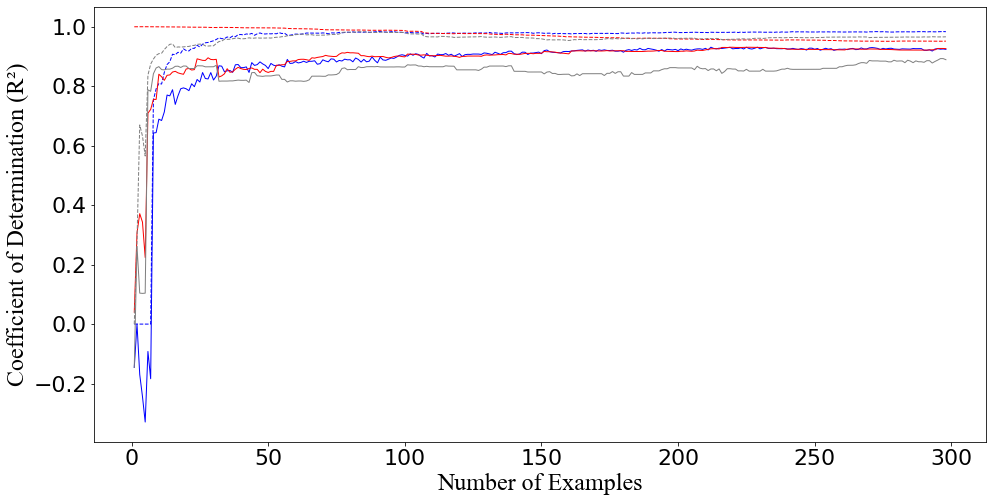

Figure saved successfully.


In [10]:
# Plot learning curves of the top 3 algorithms

np.random.seed(42)
dataset = pd.read_csv('./datasets/3_512_x_main.csv')
target = pd.read_csv('./datasets/3_512_y_main.csv')

x_values = dataset.values
y_values = target.values.ravel()

estimator1 = RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=9)
estimator2 = ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=100000)
estimator3 = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=2, p=1)

plot_multi_learning_curves(x_values, y_values, estimator1, estimator2, estimator3,
                           random_seed = 42, testsize = 0.2, mode = 'r2', autosave = 'y', interval = None)

In [11]:
# 90% of training data for model validation

def split_dataset(X, Y, random_seed=0, split_ratio=0.9):
    random.seed(random_seed)
    indices = list(range(0, len(X)))
    random.shuffle(indices)
    split_point = int(split_ratio*len(indices))
    
    train_indices = indices[:split_point]
    test_indices = indices[split_point:]
    
    x_ = np.array(X)
    y_ = np.array(Y)
    train_x = [x_[i] for i in train_indices]
    train_y = [y_[i] for i in train_indices]
    test_x = [x_[i] for i in test_indices]
    test_y = [y_[i] for i in test_indices]
    return (train_x, train_y), (test_x, test_y)

In [12]:
operation_dataset, fix_dataset = split_dataset(x, y, split_ratio=0.9)
(train_x, train_y), (test_x, test_y) = split_dataset(operation_dataset[0], operation_dataset[1], split_ratio=0.9)

In [13]:
operation_dataset[0]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [14]:
pd.DataFrame(operation_dataset[0]).to_csv('./datasets/3_512_90_x_main.csv')
pd.DataFrame(operation_dataset[1]).to_csv('./datasets/3_512_90_y_main.csv')

In [15]:
pd.DataFrame(fix_dataset[0]).to_csv('./datasets/3_512_10_x_verification.csv')

In [16]:
pd.DataFrame(fix_dataset[1]).to_csv('./datasets/3_512_10_y_verification.csv')

In [17]:
pd.DataFrame(operation_dataset[0]).shape

(337, 512)

In [18]:
pd.DataFrame(operation_dataset[1]).shape

(337, 1)

In [19]:
pd.DataFrame(operation_dataset[0]).iloc[:,1:]

1    2    3    4    5    6    7    8    9    10   ...  502  503  504  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0   
1    1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4    1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
332  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  1.0  0.0  1.0   
333  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  ...  0.0  0.0  1.0   
334  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
335  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
336  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   

     505  506  507  508  509  510  511  
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    0.0  0.0  1.0  0.0  0.0  1.0  0.0  
2    0.0  1.0  0.0  0.0  0.0  1.0  0.0  
3    1.0  0.0  1.0  0.0  0.0  1.0  0.0  
4    1.0  0.0  1.0  0.0  1.0  0.0  1.0  
..   ...  ...  ...  ...  ...  ...  ...  
332  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
333  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
334  0.0  1.0  1.0  0.0  0.0  0.0  1.0  
335  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
336  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[337 rows x 511 columns]

In [20]:
np.random.seed(42)

dataset = pd.read_csv('./datasets/3_512_90_x_main.csv').iloc[:,1:]
target = pd.read_csv('./datasets/3_512_90_y_main.csv').iloc[:,1:]
x_values = dataset.values
y_values = target.values.ravel()

In [21]:
dic = get_parameters(path = './settings/fitting_settings.json', print_dict = False)

json file path is: ./settings/fitting_settings.json


In [22]:
fit_result(x_values, y_values, KNeighborsRegressor(algorithm='ball_tree', leaf_size=20, n_neighbors=9, p=1, weights='distance'), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, Ridge(), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, Lasso(alpha=0.01, max_iter=100000), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=100000), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, GradientBoostingRegressor(criterion='squared_error', loss='huber', min_samples_split=6), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=9), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, AdaBoostRegressor(learning_rate=1), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, ExtraTreesRegressor(), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, DecisionTreeRegressor(criterion='friedman_mse', min_samples_split=7), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))
fit_result(x_values, y_values, SVR(C=10), random_seeds_start = dic.get("random_seeds_start"), random_seeds_stop = dic.get("random_seeds_stop"), random_seeds_step = dic.get("random_seeds_step"))

The average train score of all random states:0.996
The average test score of all random states:0.906
The average train rmse of all random states:0.099
The average test rmse of all random states:0.470
---------------------------------
The train score std: 0.0011
The test score std: 0.0184
The train rmse std: 0.0147
The test rmse std: 0.0461
---------------------------------
Time for fitting: 2.843434 seconds
*********************************
The average train score of all random states:0.992
The average test score of all random states:0.894
The average train rmse of all random states:0.142
The average test rmse of all random states:0.500
---------------------------------
The train score std: 0.0014
The test score std: 0.0187
The train rmse std: 0.0118
The test rmse std: 0.0462
---------------------------------
Time for fitting: 0.099704 seconds
*********************************
The average train score of all random states:0.946
The average test score of all random states:0.910
The avera

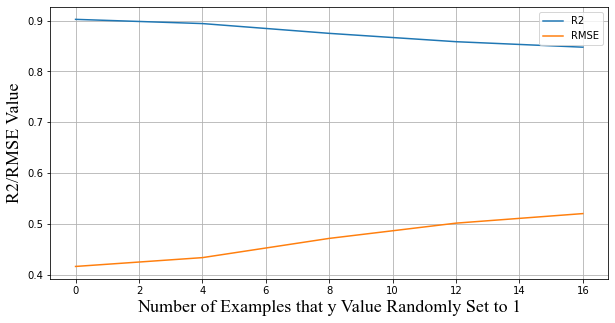

In [23]:
# Further model validation using the idea of dropout regularization

conf_r2 = []
conf_rmse = []
for i in range(0, 20, 4):
    regr = RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=9)
    x_train,x_test, y_train, y_test = train_test_split(x_values, y_values, test_size = 0.2, random_state = 42)
    regr.fit(x_train,
             np.concatenate([np.ones([i])*6, y_train[i:]]))
    y_pred = regr.predict(x_test)
    conf_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    conf_r2.append(r2_score(y_test, y_pred))
plt.figure(figsize=(10, 5))
plt.plot(list(range(0, 20, 4)), conf_r2, label='R2')
plt.plot(list(range(0, 20, 4)), conf_rmse, label='RMSE')
plt.xlabel('Number of Examples that y Value Randomly Set to 1', fontproperties = 'Times New Roman', fontsize = 18)
plt.ylabel('R2/RMSE Value', fontproperties = 'Times New Roman', fontsize = 18)
plt.grid()
plt.legend()
plt.show()

In [24]:
regr = RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=9)
x_train,x_test, y_train, y_test = train_test_split(x_values, y_values, test_size = 0.2, random_state = 42)
regr.fit(x_train,
         np.concatenate([np.ones([5])*6, y_train[5:]]))
y_pred = regr.predict(x_test)

In [25]:
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2', r2_score(y_test, y_pred))

RMSE 0.4602718170827691
R2 0.8808012419636694


In [2]:
plt.figure(figsize=(10, 5))
plt.plot(list(range(0, len(y_test))), y_test, label='Ground Truth')
plt.plot(list(range(0, len(y_pred))), y_pred, label='Prediction')
plt.xlabel('Number of Examples in Test Set', fontproperties = 'Times New Roman', fontsize = 18)
plt.ylabel('pChEMBL Value', fontproperties = 'Times New Roman', fontsize = 18)
plt.legend()
plt.grid()
plt.show()

NameError: name 'y_test' is not defined

<Figure size 720x360 with 0 Axes>